<a href="https://colab.research.google.com/github/Sayed-Ali-Raza-Naqvi/Internncraft_House_Price_Analysis_Prediction_Project/blob/main/Internncraft_House_Price_Analysis_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction Analysis.
---

## 1. Introduction
This notebook aims to analyze housing price data and build predictive models to estimate housing prices. The dataset contains various features such as property type, location, area, number of bedrooms and baths, price, etc.

## 2. Importing Libraries
We start by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 3. Data Overview
---

### 3.1 Load the Data
We begin by loading the dataset and inspecting its structure.

In [2]:
df = pd.read_csv("/content/zameen-updated.csv", parse_dates=["date_added"])

In [3]:
df.sample(3)

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
130211,17105914,10610,https://www.zameen.com/Property/bahria_town_ph...,House,43000,Bahria Town Rawalpindi,Rawalpindi,Punjab,33.501360,73.108691,3,8 Marla,For Rent,3,2019-07-05,Hussain Real Estate & Builders,Raja Rehman Ali,Marla,8.0,5-10 Marla
118104,17044395,6007,https://www.zameen.com/Property/rawalpindi_dho...,House,7500000,Dhok Elahi Baksh,Rawalpindi,Punjab,33.611724,73.068216,0,4.2 Marla,For Sale,0,2019-07-01,Khan Property Advisor,Rizwan,Marla,4.2,0-5 Marla
40941,14807501,3533,https://www.zameen.com/Property/allama_iqbal_t...,House,26500000,Allama Iqbal Town,Lahore,Punjab,31.518118,74.288764,0,10 Marla,For Sale,5,2019-06-18,Abid Estate Agency,Abid Saleem,Marla,10.0,5-10 Marla


## 3.2 Dataset Shape and Information
Check the shape of the dataset and its basic information.

In [4]:
df.shape

(168446, 20)

In [5]:
df.shape

(168446, 20)

In [6]:
df.describe()

,property_id,location_id,price,latitude,longitude,baths,bedrooms,date_added,Area Size
count,1.684460e+05,168446.000000,1.684460e+05,168446.000000,168446.000000,168446.000000,168446.000000,168446,168446.000000
mean,1.559626e+07,4375.936395,1.776576e+07,29.859519,71.239804,2.874227,3.179422,2019-05-22 04:55:12.805290752,5.892188
min,8.657500e+04,1.000000,0.000000e+00,11.052446,25.906027,0.000000,0.000000,2018-08-05 00:00:00,0.000000
25%,1.488320e+07,1058.000000,1.750000e+05,24.948536,67.130363,0.000000,2.000000,2019-05-05 00:00:00,3.000000
50%,1.665851e+07,3286.000000,8.500000e+06,31.459784,73.056182,3.000000,3.000000,2019-06-27 00:00:00,5.000000
75%,1.708662e+07,7220.000000,1.950000e+07,33.560887,73.259870,4.000000,4.000000,2019-07-05 00:00:00,8.000000
max,1.735772e+07,14220.000000,2.000000e+09,73.184088,80.161430,403.000000,68.000000,2019-07-18 00:00:00,800.000000
std,2.251207e+06,3776.561581,3.531003e+07,3.807870,3.133042,2.463400,1.971401,NaN,5.778327


## 4. Data Cleaning and Preparation
---

### 4.1 Drop Unnecessary Columns
Remove columns that have excessive missing values or are irrelevant to our analysis.

In [7]:
df.isnull().sum()

property_id          0
location_id          0
page_url             0
property_type        0
price                0
location             0
city                 0
province_name        0
latitude             0
longitude            0
baths                0
area                 0
purpose              0
bedrooms             0
date_added           0
agency           44071
agent            44072
Area Type            0
Area Size            0
Area Category        0
dtype: int64

In [8]:
df.drop(columns=["agent", "agency", "property_id", "page_url", "location_id"], inplace=True)

### 4.2 Convert Area Units
Convert the area from different units (marla and kanal) to square feet.

In [9]:
def area_sqft(area):
    marla_to_sqft = 272.25
    kanal_to_sqft = 5445

    area = area.replace(",", "")
    parts = area.split()
    number = float(parts[0])
    unit = parts[1].lower()

    if unit == "marla":
        return number * marla_to_sqft
    elif unit == "kanal":
        return number * kanal_to_sqft
    else:
        raise ValueError("Invalid Unit.")

In [10]:
df["area_in_sqft"] = df["area"].apply(area_sqft)
df.drop(columns=["Area Type", "Area Size", "Area Category", "area"], inplace=True)

### 4.3 Feature Engineering
Create new features such as total rooms, price per square foot, and age of property.

In [11]:
df["total_rooms"] = df["bedrooms"] + df["baths"]
df["multiple_bedrooms"] = (df["bedrooms"] > 1).astype(int)
df["multiple_baths"] = (df["baths"] > 1).astype(int)

df["price_per_sqft"] = df["price"] / df["area_in_sqft"]
df["rooms_per_sqft"] = df["total_rooms"] / df["area_in_sqft"]
df["baths_bedrooms_ratio"] = df["baths"] / df["bedrooms"].replace(0, np.nan)

df["year_added"] = df["date_added"].dt.year
df["month_added"] = df["date_added"].dt.month
df["age_of_property"] = pd.Timestamp.now().year - df["date_added"].dt.year

df.drop(columns=["date_added"], inplace=True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)


## 5. Exploratory Data Analysis (EDA)
---

### 5.1 Initial Data Overview
View basic statistics and the distribution of features.

In [12]:
df.describe(include='all')

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,area_in_sqft,total_rooms,multiple_bedrooms,multiple_baths,price_per_sqft,rooms_per_sqft,baths_bedrooms_ratio,year_added,month_added,age_of_property
count,168446,1.684460e+05,168446,168446,168446,168446.000000,168446.000000,168446.000000,168446,168446.000000,1.684460e+05,168446.000000,168446.000000,168446.000000,1.684460e+05,168446.000000,168446.000000,168446.000000,168446.000000,168446.000000
unique,7,NaN,1509,5,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,House,NaN,DHA Defence,Karachi,Punjab,NaN,NaN,NaN,For Sale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,105468,NaN,22046,60484,70536,NaN,NaN,NaN,120655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.776576e+07,NaN,NaN,NaN,29.859519,71.239804,2.874227,NaN,3.179422,3.934906e+03,6.053649,0.838892,0.716598,6.095608e+03,0.003016,0.785220,2018.927270,6.181607,5.072730
std,NaN,3.531003e+07,NaN,NaN,NaN,3.807870,3.133042,2.463400,NaN,1.971401,1.273957e+05,4.056426,0.367632,0.450651,1.710970e+04,0.002970,0.521726,0.259693,1.871444,0.259693
min,NaN,0.000000e+00,NaN,NaN,NaN,11.052446,25.906027,0.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2018.000000,1.000000,5.000000
25%,NaN,1.750000e+05,NaN,NaN,NaN,24.948536,67.130363,0.000000,NaN,2.000000,1.306800e+03,4.000000,1.000000,0.000000,4.591368e+01,0.001469,0.000000,2019.000000,6.000000,5.000000
50%,NaN,8.500000e+06,NaN,NaN,NaN,31.459784,73.056182,3.000000,NaN,3.000000,1.932975e+03,6.000000,1.000000,1.000000,5.876951e+03,0.002755,1.000000,2019.000000,6.000000,5.000000
75%,NaN,1.950000e+07,NaN,NaN,NaN,33.560887,73.259870,4.000000,NaN,4.000000,3.267000e+03,9.000000,1.000000,1.000000,8.723600e+03,0.004081,1.000000,2019.000000,7.000000,5.000000


### 5.2 Univariate Analysis
Analyze the distribution of numerical and categorical features.

In [13]:
sample_df = df.sample(frac=0.1, random_state=42)

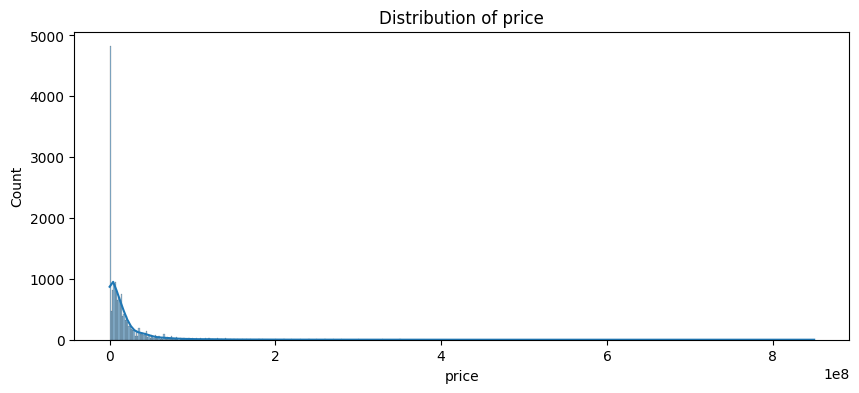

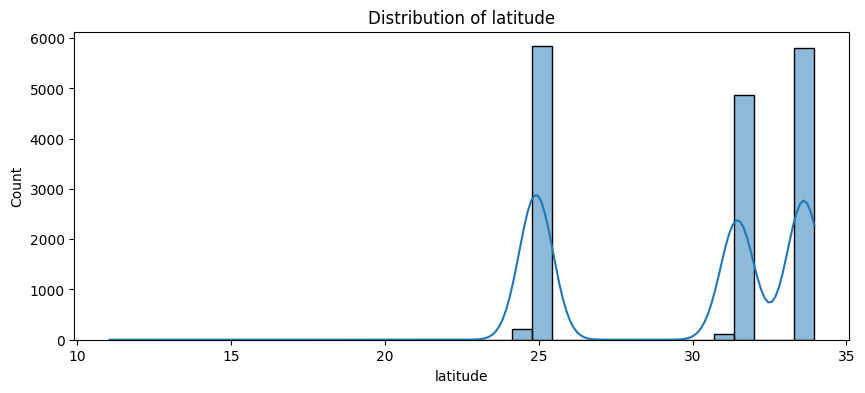

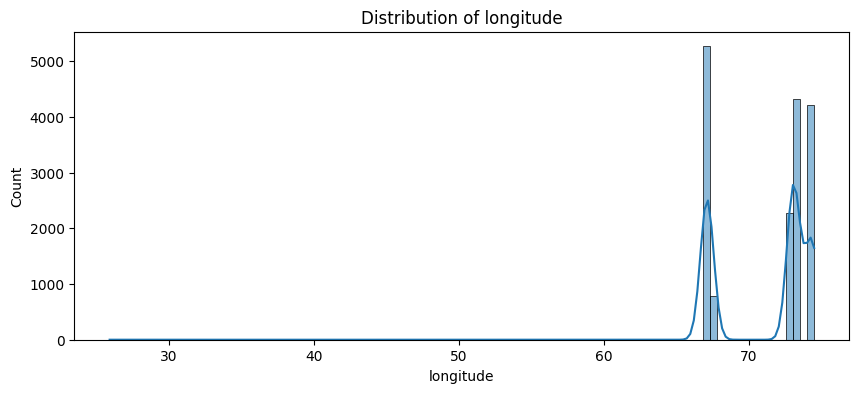

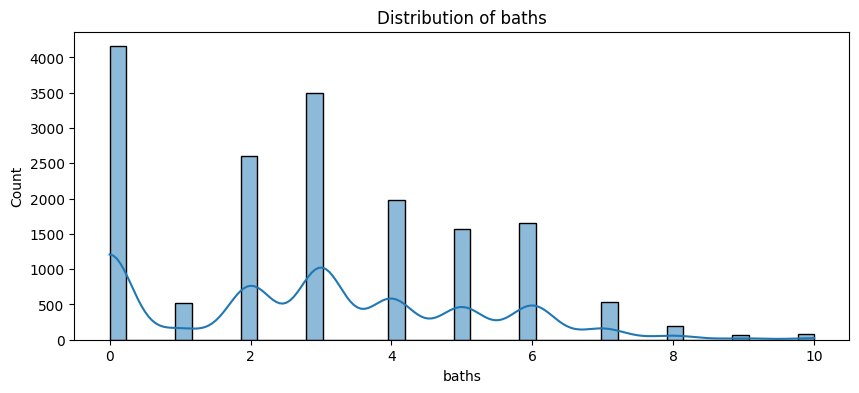

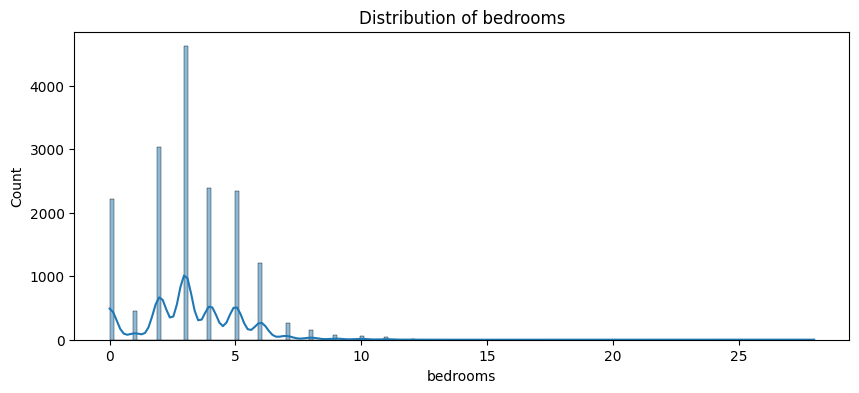

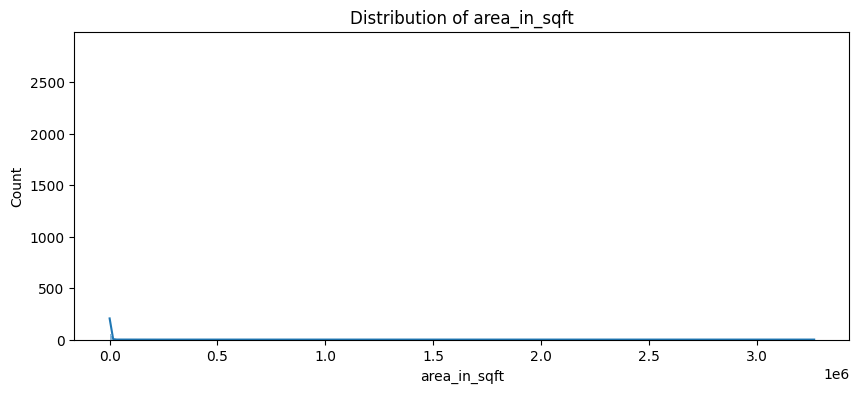

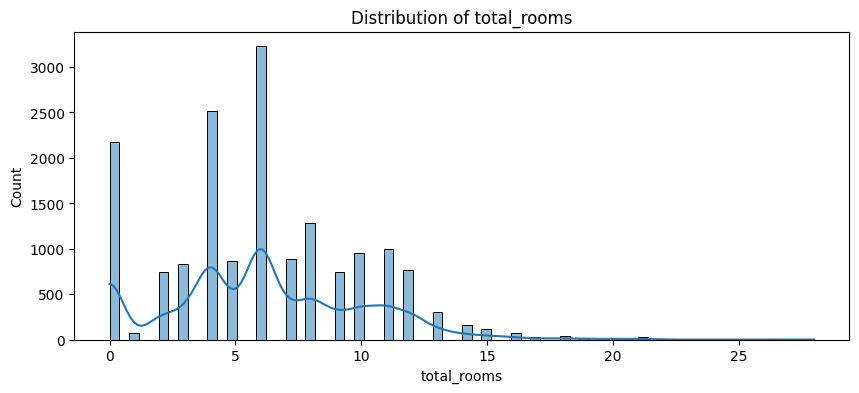

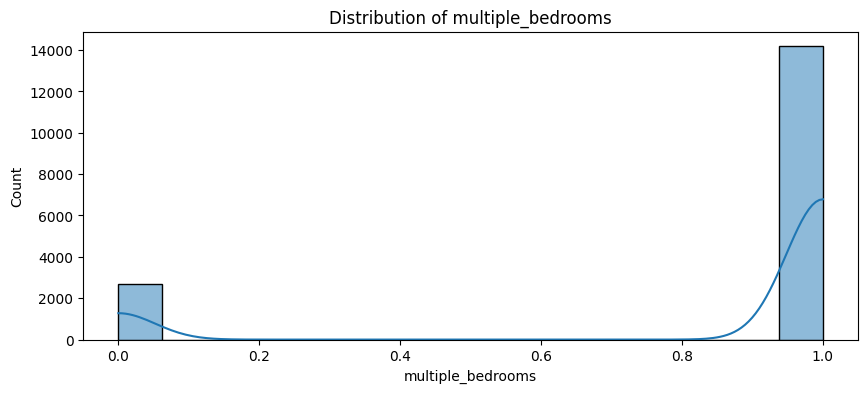

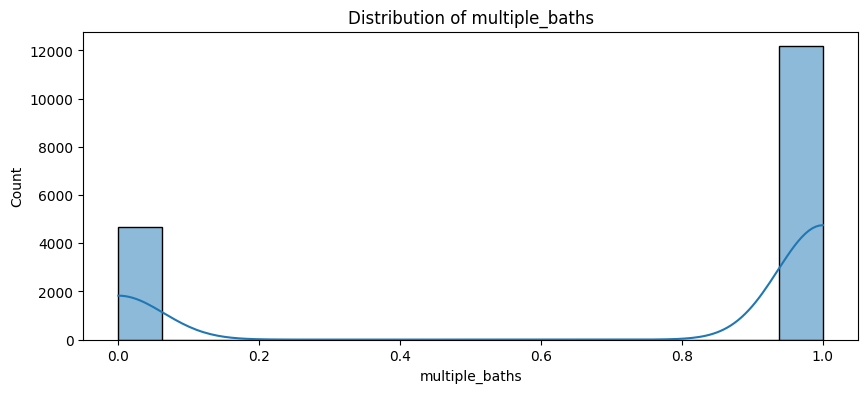

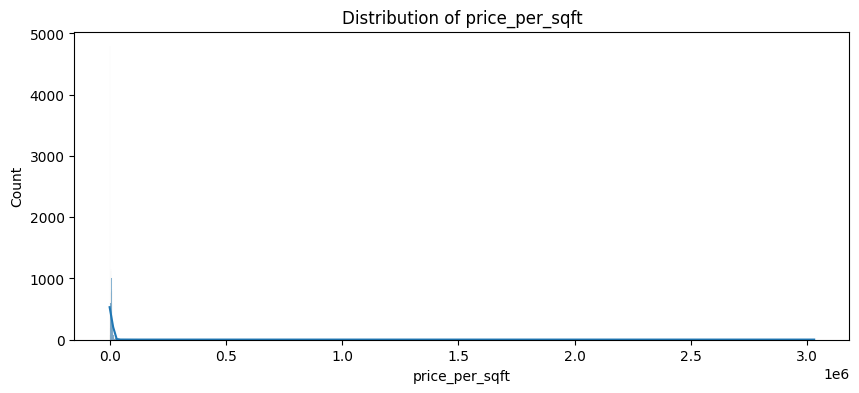

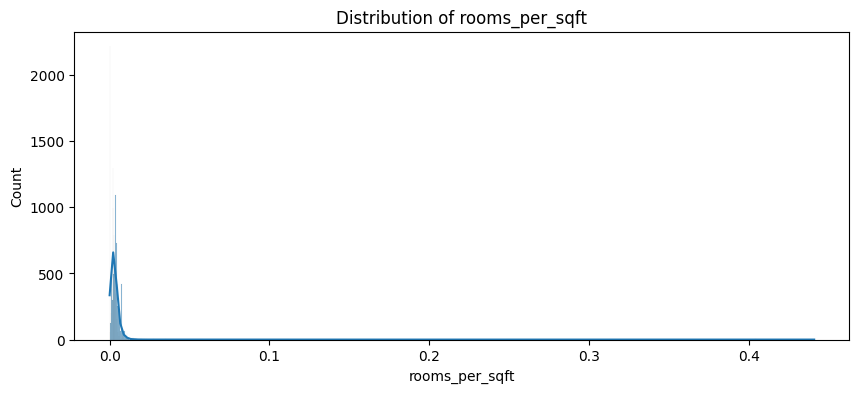

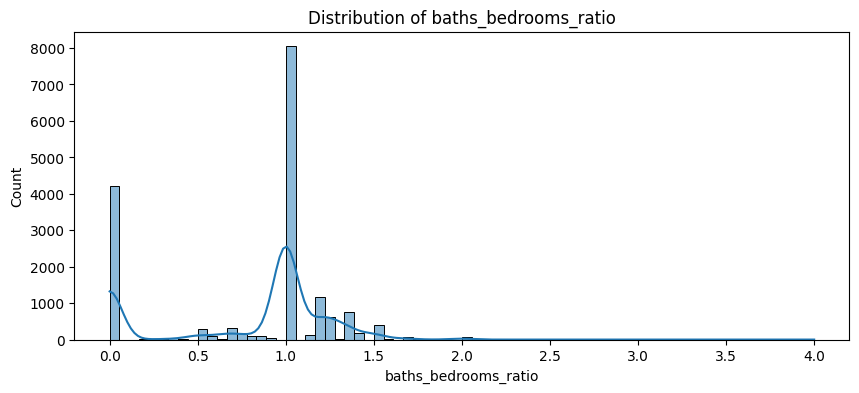

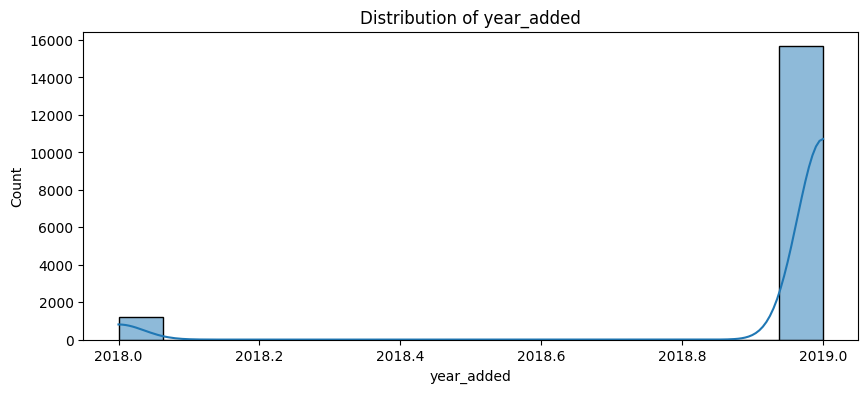

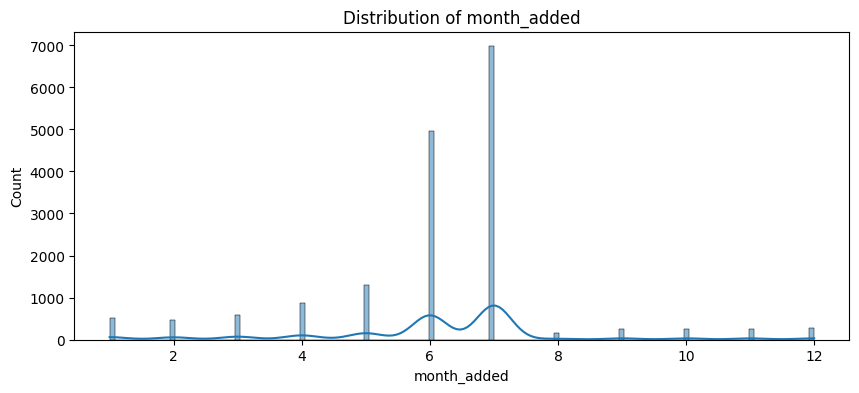

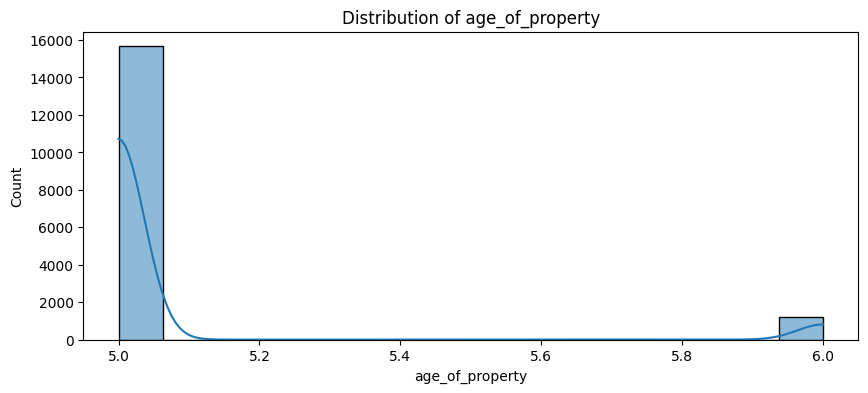

In [14]:
numerical_features = sample_df.select_dtypes(include=[np.number]).columns

for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(sample_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

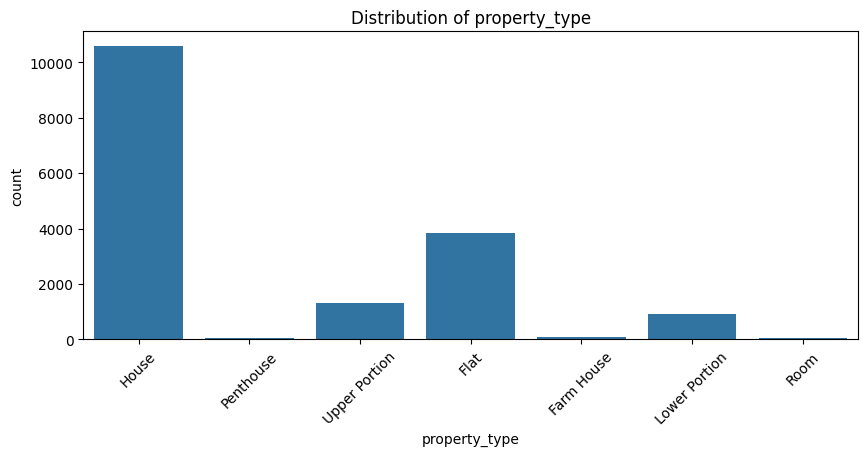

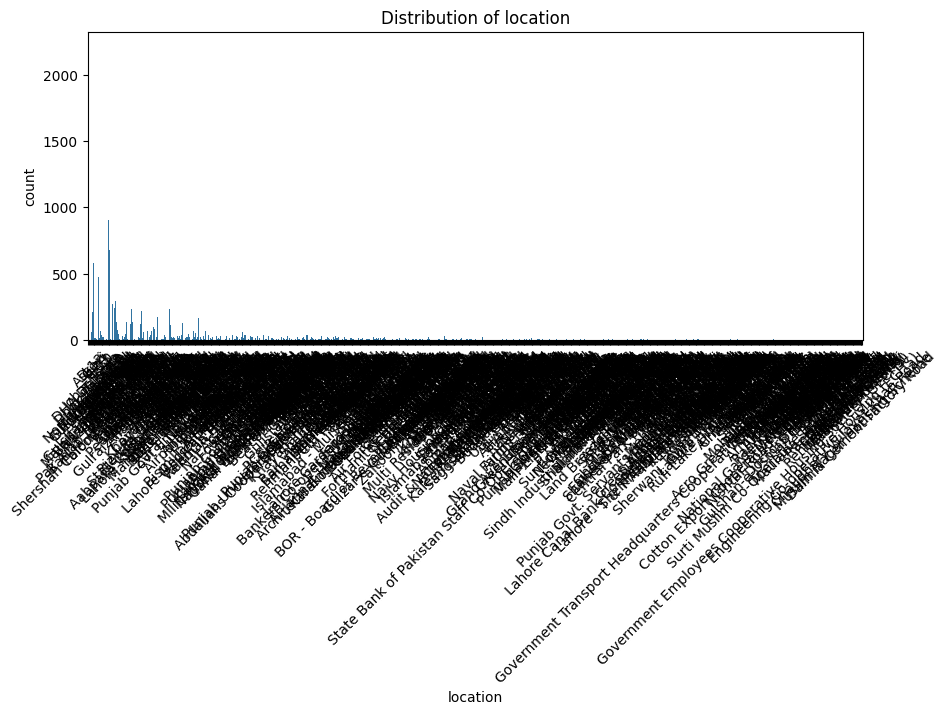

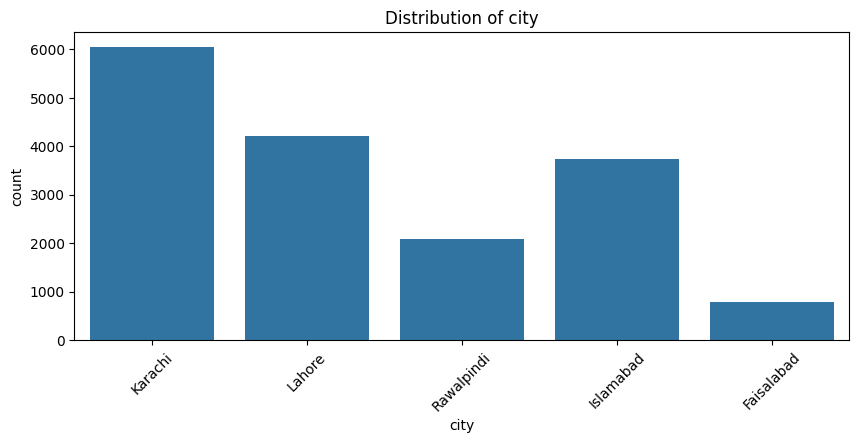

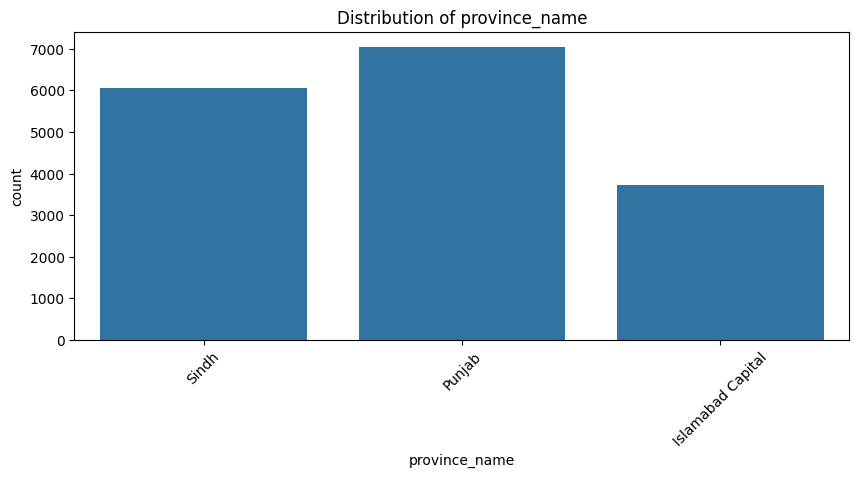

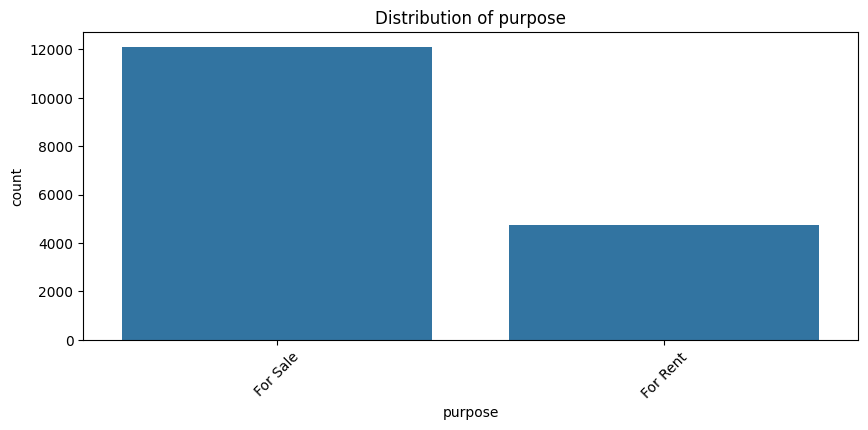

In [15]:
categorical_features = sample_df.select_dtypes(include=[object]).columns

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=sample_df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

### 5.3 Bivariate Analysis
Examine relationships between features and the target variable (price).

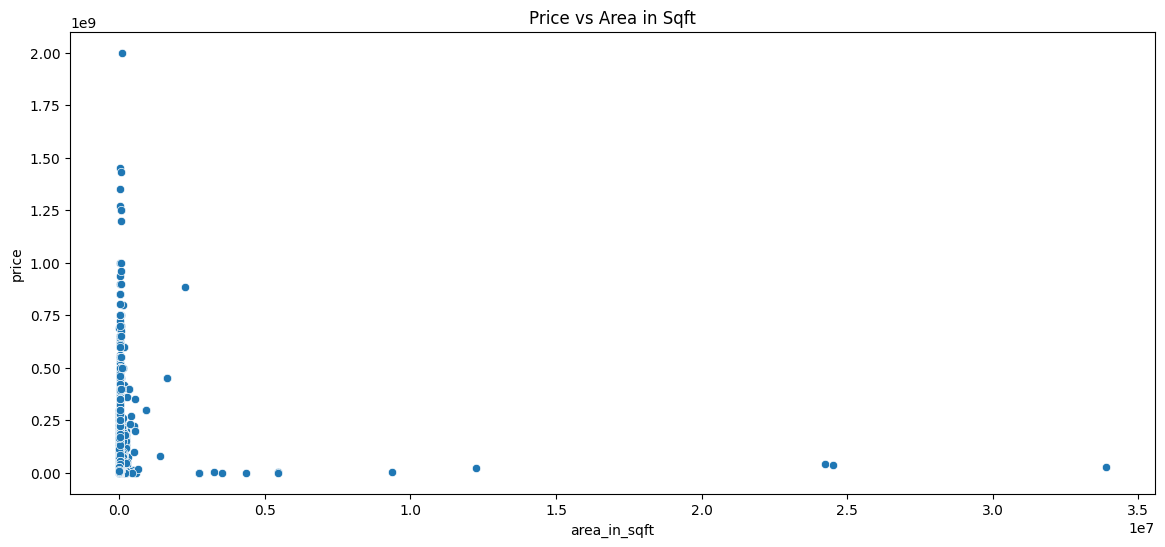

In [16]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='area_in_sqft', y='price', data=df)
plt.title('Price vs Area in Sqft')
plt.show()

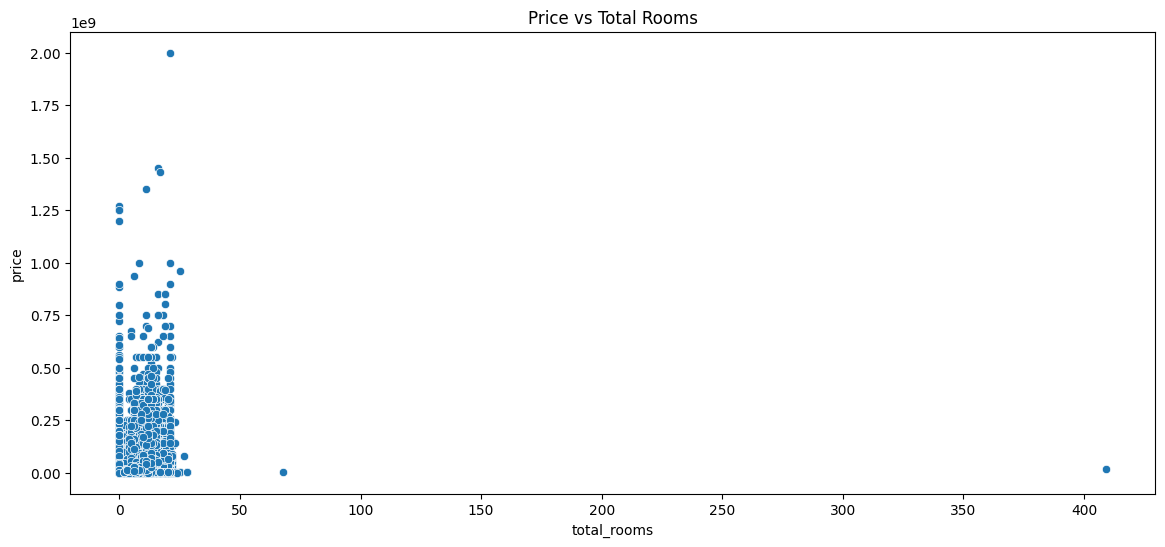

In [17]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='total_rooms', y='price', data=df)
plt.title('Price vs Total Rooms')
plt.show()

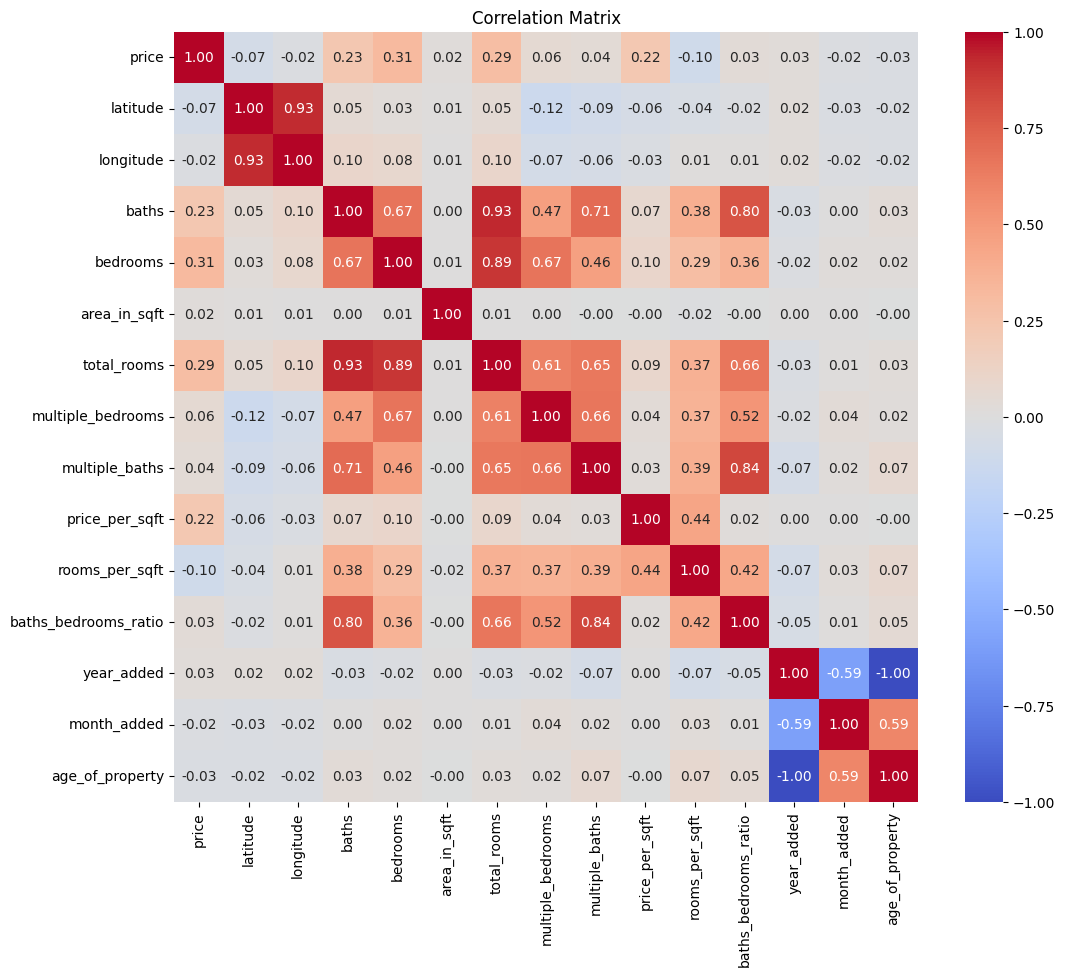

In [18]:
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 5.4 Box Plots for Categorical Features
Visualize the distribution of price by different categorical features.

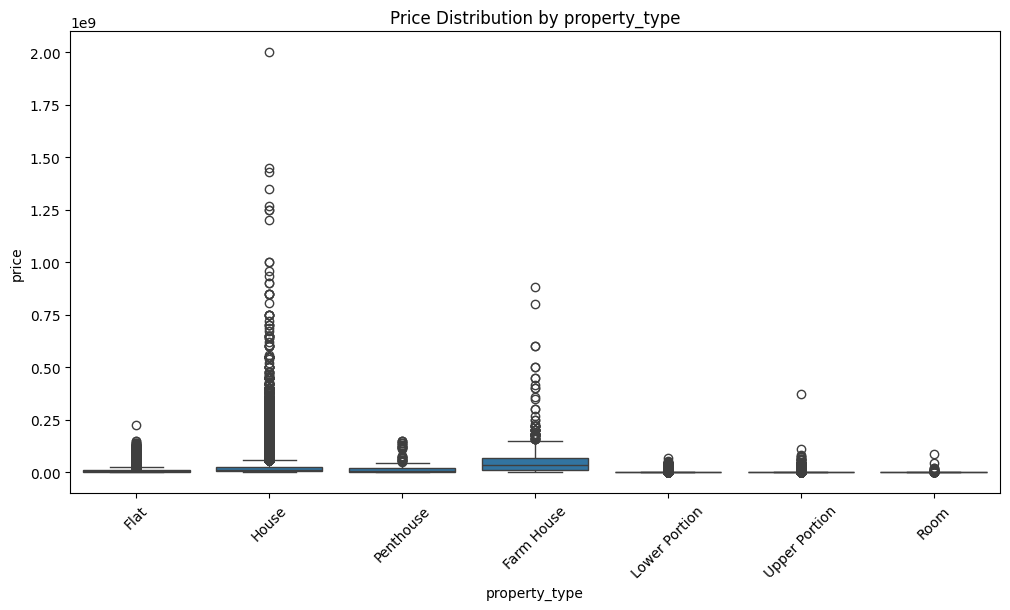

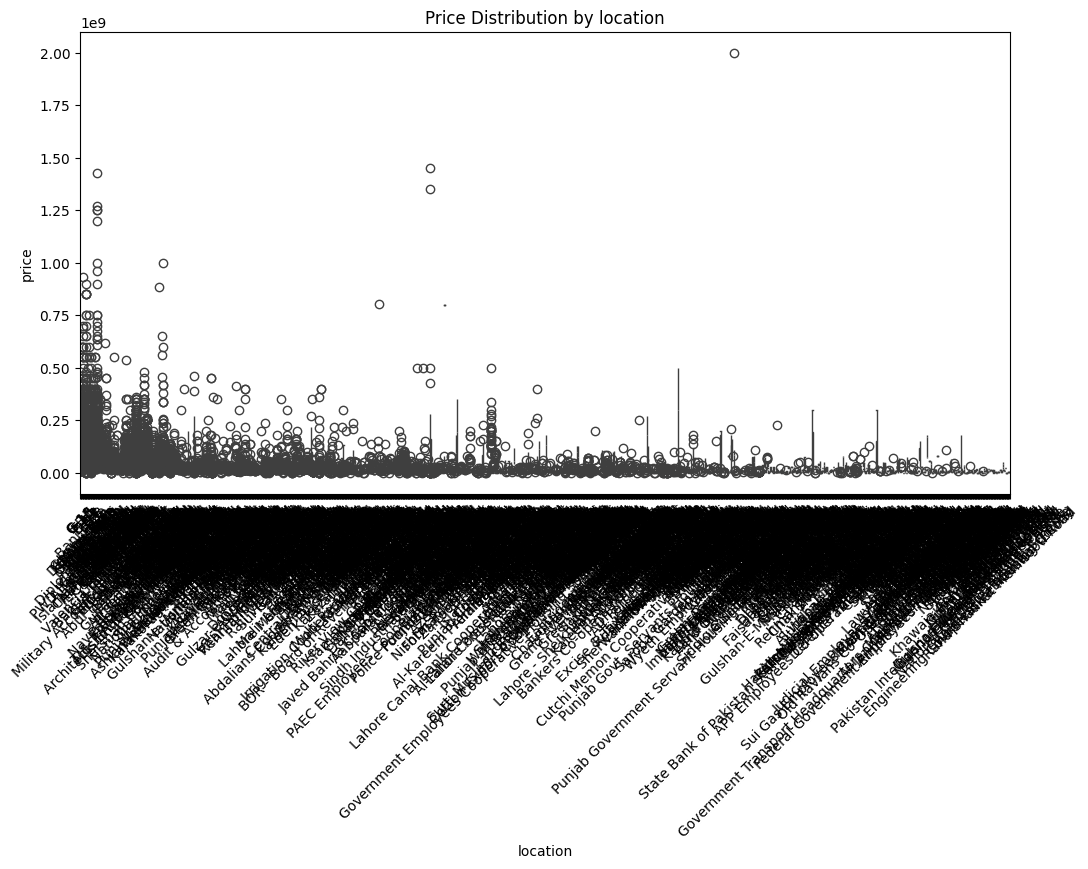

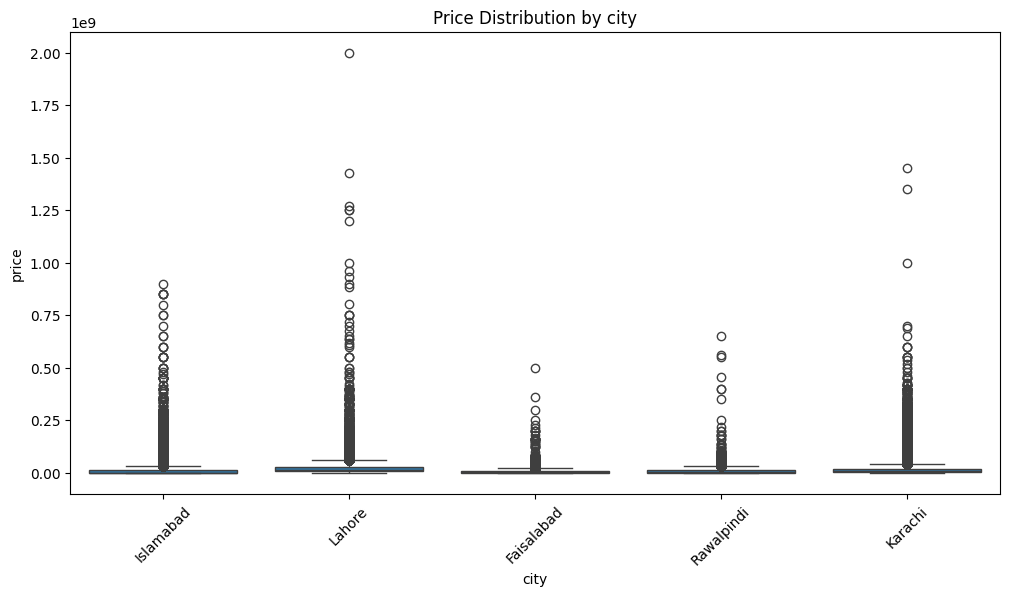

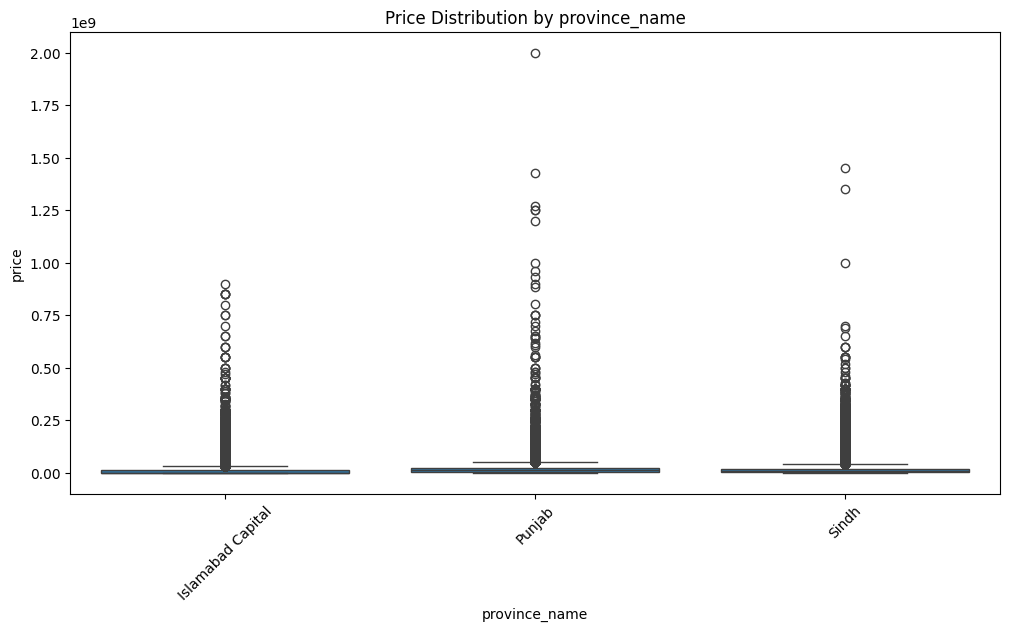

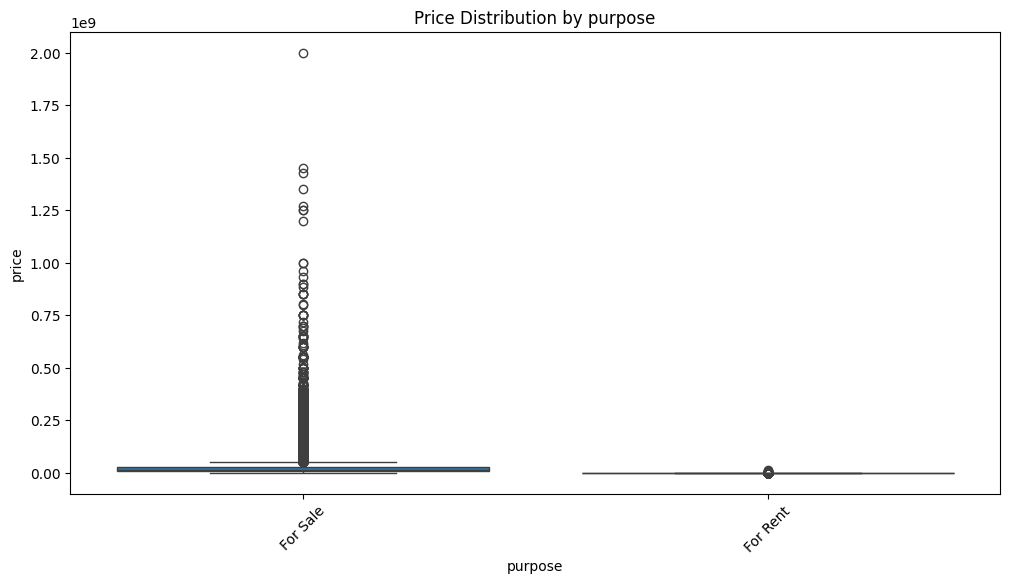

In [19]:
for feature in categorical_features:
    if feature != 'price':
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df[feature], y=df['price'])
        plt.title(f'Price Distribution by {feature}')
        plt.xticks(rotation=45)
        plt.show()

### 5.5 Outlier Detection and Removal
Detect and remove outliers using IQR and Isolation Forest.

In [20]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'price')

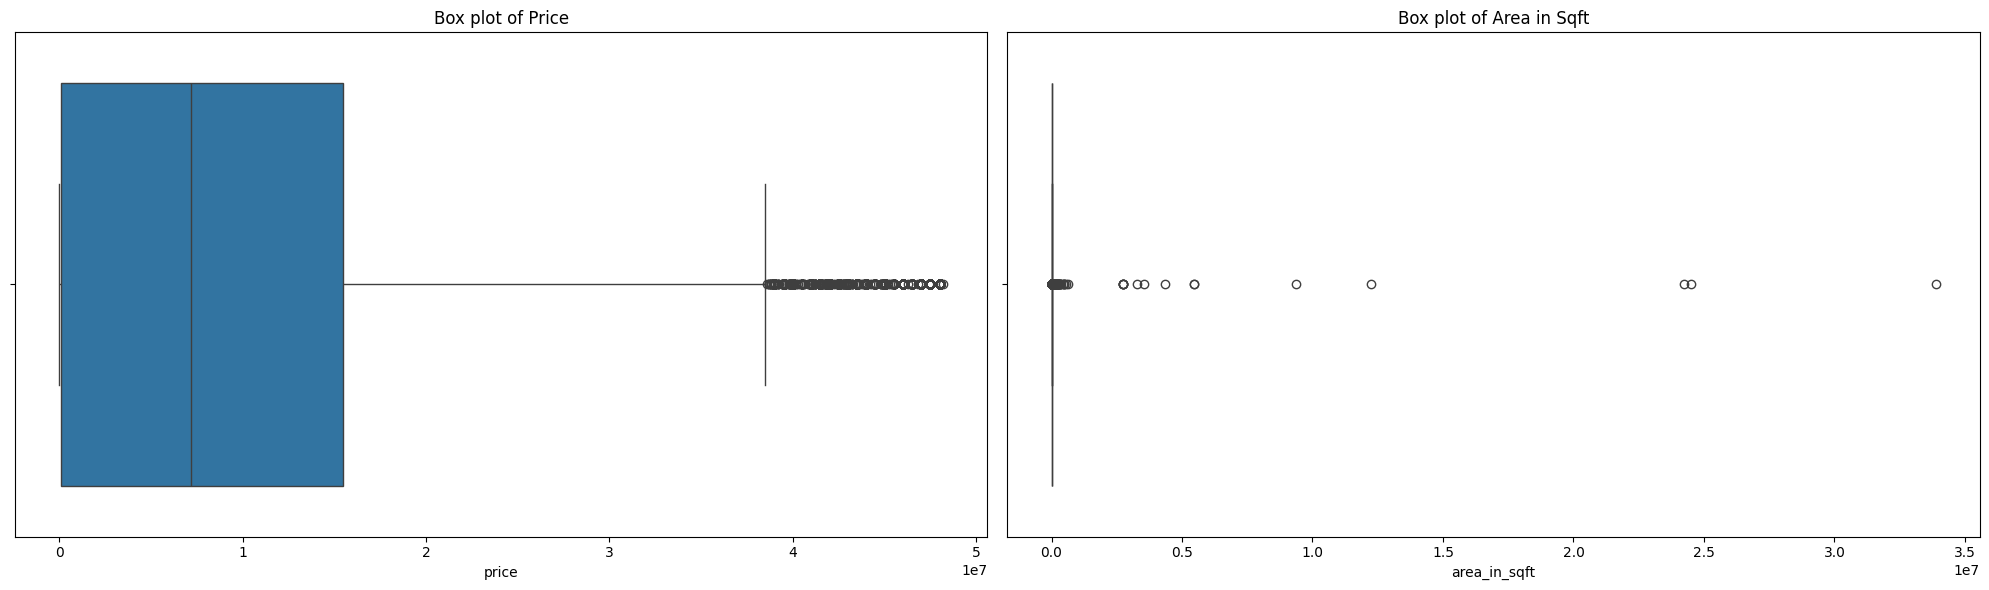

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.boxplot(x=df['price'], ax=axes[0])
axes[0].set_title('Box plot of Price')

sns.boxplot(x=df['area_in_sqft'], ax=axes[1])
axes[1].set_title('Box plot of Area in Sqft')

plt.tight_layout()
plt.show()

In [22]:
df['price_log'] = np.log1p(df['price'])
df['area_in_sqft_log'] = np.log1p(df['area_in_sqft'])

In [23]:
iso = IsolationForest(contamination=0.1, random_state=42)
outliers = iso.fit_predict(df[['price', 'area_in_sqft']])
df = df[outliers == 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


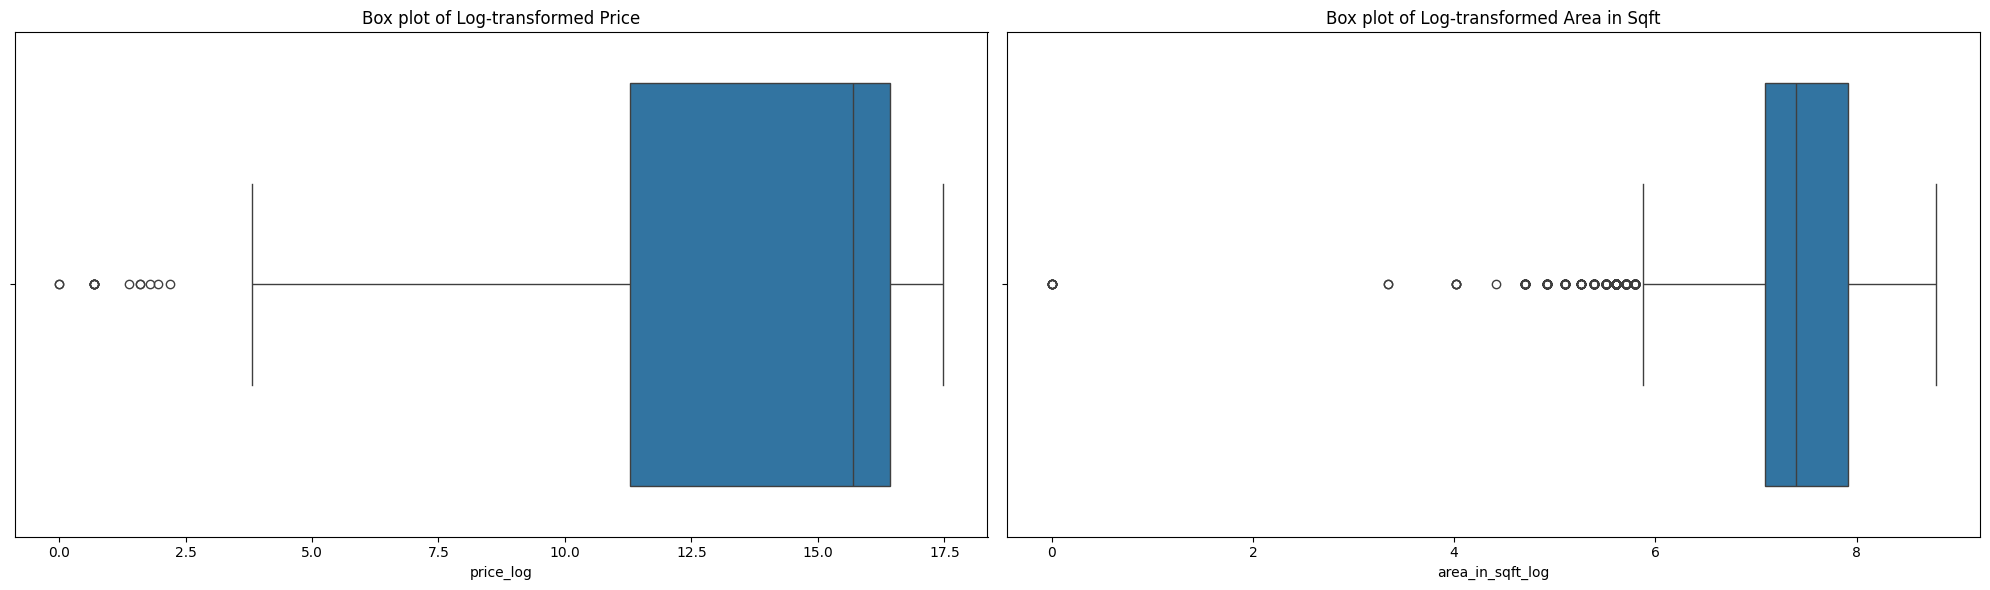

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.boxplot(x=df['price_log'], ax=axes[0])
axes[0].set_title("Box plot of Log-transformed Price")

sns.boxplot(x=df['area_in_sqft_log'], ax=axes[1])
axes[1].set_title("Box plot of Log-transformed Area in Sqft")

plt.tight_layout()
plt.show()

## 6. Modeling
---

### 6.1 Data Preparation
Scale the numerical features and label encode the categorical features to prepare the data for modeling.

In [32]:
categorical_columns = ["property_type", "location", "city", "province_name", "purpose"]
encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = encoder.fit_transform(df[column])

In [33]:
x = df.drop(["price", "price_log"], axis=1)
y = df["price"]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### 6.2 Linear Regression
Train and evaluate a Linear Regression model.

In [36]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred_lr = lr.predict(x_test_scaled)

In [38]:
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_score_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression R^2 Score: {r2_score_lr:.2f}')

Linear Regression RMSE: 3296455.96
Linear Regression R^2 Score: 0.85


### 6.3 Random Forest Regression
Train and evaluate a Random Forest model.

In [39]:
rf = RandomForestRegressor()
rf.fit(x_train_scaled, y_train)
y_pred_rf = rf.predict(x_test_scaled)

In [40]:
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_score_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'Random Forest R^2 Score: {r2_score_rf:.2f}')

Random Forest RMSE: 63041.75
Random Forest R^2 Score: 1.00


In [46]:
average_price = y_test.mean()
percentage_error = (rmse_rf / average_price) * 100
print(f'Percentage Error: {percentage_error:.2f}%')

Percentage Error: 0.75%


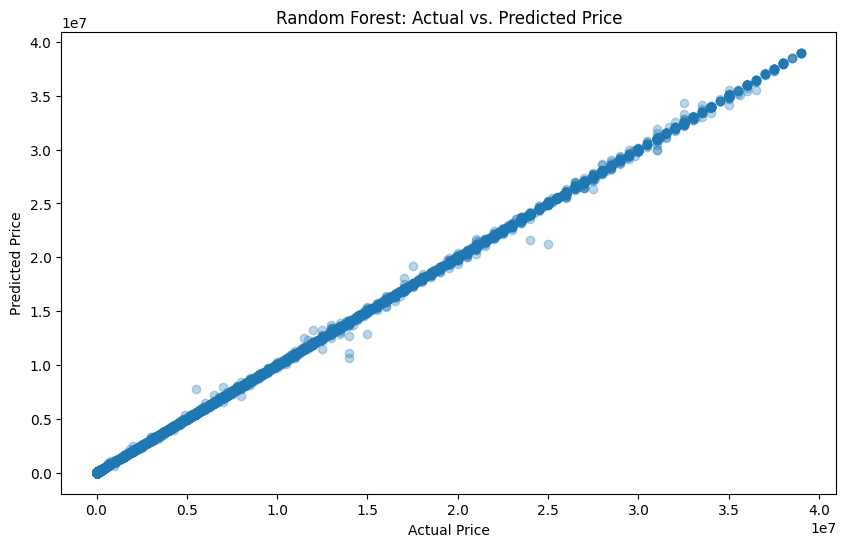

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs. Predicted Price')
plt.show()

### 6.4 XGBoost Regression
Train and evaluate an XGBoost model.

In [41]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(x_train_scaled, y_train)
y_pred_xgb = xgb.predict(x_test_scaled)

In [43]:
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_score_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'XGBoost R^2 Score: {r2_score_xgb:.2f}')

XGBoost RMSE: 162665.48
XGBoost R^2 Score: 1.00


## 7. Conclusion
In this report, we performed a thorough exploratory data analysis and built several predictive models for housing prices. We examined the data distribution, detected and handled outliers, and evaluated multiple regression models, including Linear Regression, Random Forest, and XGBoost. Each model's performance was assessed using RMSE and R^2 score to determine their effectiveness in predicting property prices.